# Audio Inference and Inspection

In [74]:
import sys
from pathlib import Path
import torch
import torch.nn as nn
import torchaudio
import soundfile as sf
import numpy as np
import matplotlib.pyplot as plt
from IPython.display import Audio
import random
import warnings
warnings.filterwarnings("ignore", category=UserWarning)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Device: {device}")

Device: cuda


# Load The Encodec Model and Initialize it

In [75]:
from encodec import EncodecModel
from encodec.utils import convert_audio


class AudioCodec(nn.Module):
    def __init__(self, bandwidth=6.0):
        super().__init__()
        self.model = EncodecModel.encodec_model_24khz()
        self.model.set_target_bandwidth(bandwidth)
        self.bandwidth = bandwidth
        self.sample_rate = 24000

    def forward(self, waveform):
        with torch.no_grad():
            encoded_frames = self.model.encode(waveform)
        
        codes, scale = encoded_frames[0]
        
        with torch.no_grad():
            decoded = self.model.decode(encoded_frames)
        
        return decoded, codes
    
    def encode(self, waveform):
        with torch.no_grad():
            encoded_frames = self.model.encode(waveform)
        return encoded_frames
    
    def decode(self, encoded_frames):
        with torch.no_grad():
            decoded = self.model.decode(encoded_frames)
        return decoded
    
    @classmethod
    def from_pretrained(cls, bandwidth=6.0):
        return cls(bandwidth=bandwidth)

codec = AudioCodec(bandwidth=6.0);
codec.to(device);
codec.eval();

print(f"EnCodec model loaded")
print(f"Sample rate: {codec.sample_rate}")
print(f"Bandwidth: {codec.bandwidth} kbps")

/home/dani/Documents/Bharani/Diffusion_PreTrained/.venv/lib/python3.14/site-packages/torch/nn/utils/weight_norm.py:144: FutureWarning: `torch.nn.utils.weight_norm` is deprecated in favor of `torch.nn.utils.parametrizations.weight_norm`.
  WeightNorm.apply(module, name, dim)


EnCodec model loaded
Sample rate: 24000
Bandwidth: 6.0 kbps


## Load Audio Waveform

In [76]:
test_files = list(Path("data/raw/test-clean").rglob("*.flac"))
test_file = random.choice(test_files)

waveform, sr = torchaudio.load(test_file)

if sr != 24000:
    waveform = torchaudio.functional.resample(waveform, orig_freq=sr, new_freq=24000)

if waveform.shape[0] > 1:
    waveform = waveform.mean(dim=0, keepdim=True)

waveform = waveform.unsqueeze(0)

print(f"Given Audio: {test_file}")
print(f"Audio shape: {waveform.shape}")
print(f"Duration (sec): {waveform.shape[-1] / 24000:.2f}s")

Given Audio: data/raw/test-clean/4970/29093/4970-29093-0002.flac
Audio shape: torch.Size([1, 1, 257520])
Duration (sec): 10.73s


## Visualize Waveform

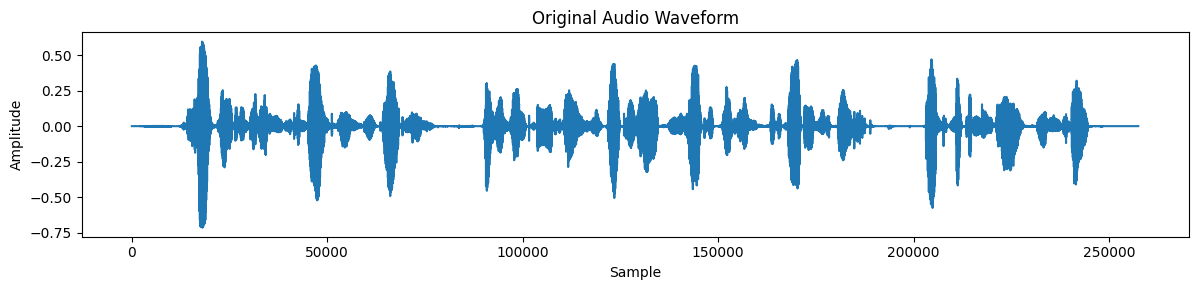

In [77]:
plt.figure(figsize=(12, 3))
plt.plot(waveform[0, 0].cpu().numpy())
plt.title('Original Audio Waveform')
plt.xlabel('Sample')
plt.ylabel('Amplitude')
plt.tight_layout()
plt.show()

## Encode and Decode

In [78]:
audio = waveform.to(device)

with torch.no_grad():
    encoded_frames = codec.encode(audio)
    audio_reconstructed = codec.decode(encoded_frames)

print(f"Original shape: {audio.shape}")
print(f"Reconstructed shape: {audio_reconstructed.shape}")
print(f"Reconstruction complete")

Original shape: torch.Size([1, 1, 257520])
Reconstructed shape: torch.Size([1, 1, 257600])
Reconstruction complete


## Compare Waveforms

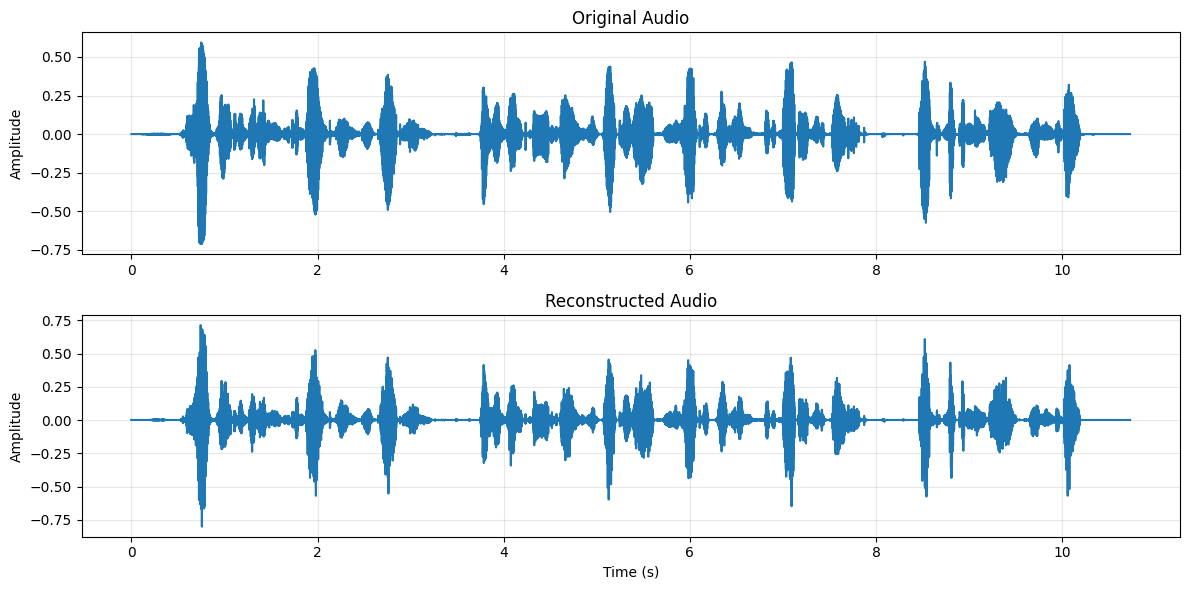

In [79]:
fig, axes = plt.subplots(2, 1, figsize=(12, 6))

audio_orig_np = audio[0, 0].cpu().numpy()
audio_recon_np = audio_reconstructed[0, 0].cpu().numpy()[:audio_orig_np.shape[0]]

time_axis = np.arange(len(audio_orig_np)) / 24000

axes[0].plot(time_axis, audio_orig_np)
axes[0].set_title('Original Audio')
axes[0].set_ylabel('Amplitude')
axes[0].grid(True, alpha=0.3)

axes[1].plot(time_axis, audio_recon_np)
axes[1].set_title('Reconstructed Audio')
axes[1].set_xlabel('Time (s)')
axes[1].set_ylabel('Amplitude')
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

## Play Audio

In [80]:
print("Original Audio:")
display(Audio(data=audio[0, 0].cpu().numpy(), rate=24000))

print("\nReconstructed Audio:")
display(Audio(data=audio_reconstructed[0, 0].cpu().numpy(), rate=24000))

Original Audio:



Reconstructed Audio:


## Save Files

In [81]:
audio_orig_save = audio[0, 0].cpu().numpy()
audio_recon_save = audio_reconstructed[0, 0].cpu().numpy()[:audio_orig_save.shape[0]]

sf.write('original.wav', audio_orig_save, 24000)
sf.write('reconstructed.wav', audio_recon_save, 24000)

print("Saved: original.wav, reconstructed.wav")

Saved: original.wav, reconstructed.wav


## Performance Metrics

In [82]:
import time
from pesq import pesq as pesq_score
from pystoi import stoi

audio_orig_save = audio[0, 0].cpu().numpy()
audio_recon_save = audio_reconstructed[0, 0].cpu().numpy()[:audio_orig_save.shape[0]]

latencies = []
for _ in range(5):
    start = time.perf_counter()
    with torch.no_grad():
        enc = codec.encode(audio.to(device))
        dec = codec.decode(enc)
    latency_ms = (time.perf_counter() - start) * 1000
    latencies.append(latency_ms)

avg_latency = np.mean(latencies)
max_latency = np.max(latencies)

encoded_frames = codec.encode(audio.to(device))
codes, scale = encoded_frames[0]
codes_bytes = codes.numel() * 4
duration_sec = audio.shape[-1] / 24000
bitrate_kbps = (codes_bytes * 8) / (duration_sec * 1000)

audio_orig_16k = torchaudio.functional.resample(
    torch.from_numpy(audio_orig_save).unsqueeze(0),
    orig_freq=24000, new_freq=16000
).squeeze(0).numpy()

audio_recon_16k = torchaudio.functional.resample(
    torch.from_numpy(audio_recon_save).unsqueeze(0),
    orig_freq=24000, new_freq=16000
).squeeze(0).numpy()

pesq_val = pesq_score(16000, audio_orig_16k, audio_recon_16k, 'wb')
stoi_val = stoi(audio_orig_16k, audio_recon_16k, 16000)
mse = np.mean((audio_orig_np - audio_recon_np) ** 2)
snr = 10 * np.log10(np.mean(audio_orig_np ** 2) / (mse + 1e-10))

print(f"Latency (avg): {avg_latency:.2f} ms")
print(f"Latency (max): {max_latency:.2f} ms")
print(f"Bitrate: {bitrate_kbps:.2f} kbps")
print(f"PESQ: {pesq_val:.2f}")
print(f"STOI: {stoi_val:.3f}")
print(f"MSE: {mse:.6f}")
print(f"SNR: {snr:.2f} dB")
print()
print("Target Specs:")
print(f"Latency < 20 ms: {'PASS' if avg_latency < 20 else 'FAIL'}")
print(f"Bitrate 8-16 kbps: {'PASS' if 8 <= bitrate_kbps <= 16 else 'FAIL'}")
print(f"PESQ ≥ 3.5: {'PASS' if pesq_val >= 3.5 else 'FAIL'}")
print(f"STOI ≥ 0.9: {'PASS' if stoi_val >= 0.9 else 'FAIL'}")

Latency (avg): 81.41 ms
Latency (max): 87.62 ms
Bitrate: 19.21 kbps
PESQ: 2.68
STOI: 0.948
MSE: 0.001238
SNR: 3.67 dB

Target Specs:
Latency < 20 ms: FAIL
Bitrate 8-16 kbps: FAIL
PESQ ≥ 3.5: FAIL
STOI ≥ 0.9: PASS


## Bandwidth Optimization

In [83]:
bandwidths_all = [1.5, 3.0, 6.0, 12.0, 24.0]
results_all = []

print("Complete Bandwidth Analysis")
print()

for bw in bandwidths_all:
    codec_test = AudioCodec(bandwidth=bw).to(device).eval()
    
    latencies_bw = []
    for _ in range(3):
        start = time.perf_counter()
        with torch.no_grad():
            enc_test = codec_test.encode(audio.to(device))
            dec_test = codec_test.decode(enc_test)
        latency_ms = (time.perf_counter() - start) * 1000
        latencies_bw.append(latency_ms)
    avg_latency_bw = np.mean(latencies_bw)
    
    dec_np = dec_test.squeeze().cpu().numpy()
    if len(dec_np.shape) > 1:
        dec_np = dec_np[0]
    dec_np = dec_np[:audio_orig_save.shape[0]]
    
    codes_test, _ = enc_test[0]
    codes_bytes_test = codes_test.numel() * 4
    bitrate_test = (codes_bytes_test * 8) / (duration_sec * 1000)
    
    dec_16k = torchaudio.functional.resample(
        torch.from_numpy(dec_np).unsqueeze(0),
        orig_freq=24000, new_freq=16000
    ).squeeze(0).numpy()
    
    pesq_test = pesq_score(16000, audio_orig_16k, dec_16k, 'wb')
    stoi_test = stoi(audio_orig_16k, dec_16k, 16000)
    
    results_all.append({
        'bandwidth': bw,
        'bitrate': bitrate_test,
        'pesq': pesq_test,
        'stoi': stoi_test,
        'latency': avg_latency_bw
    })
    
    pesq_ok = "PASS" if pesq_test >= 3.5 else "FAIL"
    stoi_ok = "PASS" if stoi_test >= 0.9 else "FAIL"
    br_ok = "PASS" if 8 <= bitrate_test <= 16 else "FAIL"
    lat_ok = "PASS" if avg_latency_bw < 20 else "FAIL"
    print(f"BW {bw:5.1f}: PESQ {pesq_ok} ({pesq_test:.2f}) | STOI {stoi_ok} ({stoi_test:.3f}) | BR {br_ok} ({bitrate_test:6.2f} kbps) | LAT {lat_ok} ({avg_latency_bw:6.2f} ms)")



Complete Bandwidth Analysis

BW   1.5: PESQ FAIL (1.47) | STOI FAIL (0.843) | BR FAIL (  4.80 kbps) | LAT FAIL ( 76.97 ms)
BW   3.0: PESQ FAIL (1.98) | STOI PASS (0.907) | BR PASS (  9.60 kbps) | LAT FAIL ( 77.20 ms)
BW   6.0: PESQ FAIL (2.68) | STOI PASS (0.948) | BR FAIL ( 19.21 kbps) | LAT FAIL ( 78.48 ms)
BW  12.0: PESQ FAIL (3.25) | STOI PASS (0.970) | BR FAIL ( 38.41 kbps) | LAT FAIL ( 79.01 ms)
BW  24.0: PESQ PASS (3.53) | STOI PASS (0.980) | BR FAIL ( 76.82 kbps) | LAT FAIL ( 81.27 ms)
